# Градиентный бустинг

Сравнение трех разобранных алгоритмов бустинга и подбор гиперпараметров для получения лучшего качества.

**Источник данных**: https://www.kaggle.com/ronitf/heart-disease-uci

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df = pd.read_csv("datasets/13/heart.csv")
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


# EDA

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


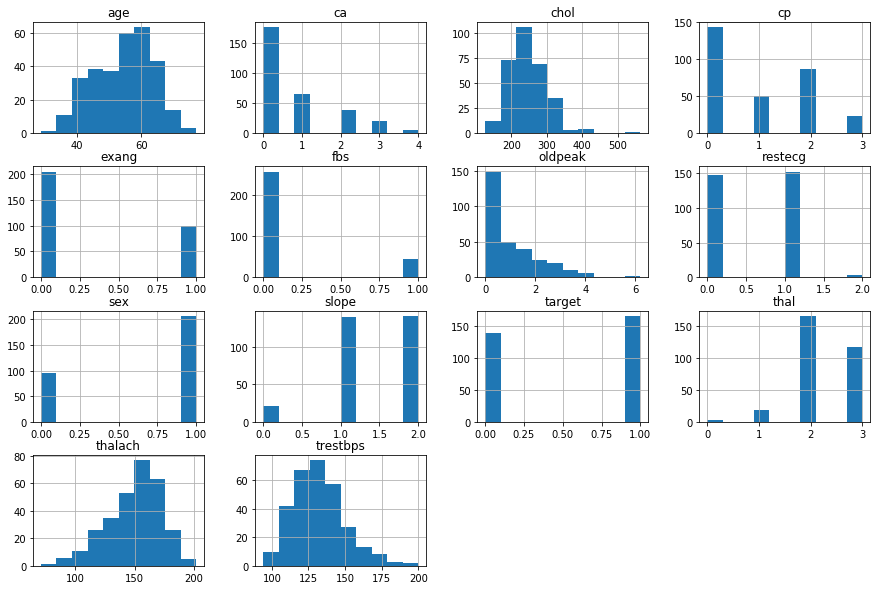

In [13]:
df.hist(figsize=(15,10))
plt.show()

In [14]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

## Correlation

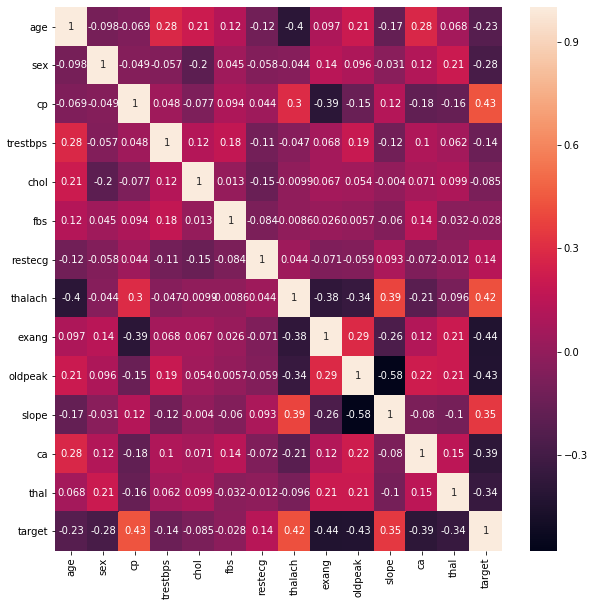

In [17]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()

In [40]:
# Находим пары признаков с коэффициентом корреляции больше 0.6
corr = df.corr()

CorField = []
for i in corr:
    for j in corr.index[corr[i] > 0.2]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            print("[{}] -> [{}]: {}".format(i, j, '%.4f' % corr[i][corr.index == j].values[0]))

[age] -> [trestbps]: 0.2794
[age] -> [chol]: 0.2137
[age] -> [oldpeak]: 0.2100
[age] -> [ca]: 0.2763
[sex] -> [thal]: 0.2100
[cp] -> [thalach]: 0.2958
[cp] -> [target]: 0.4338


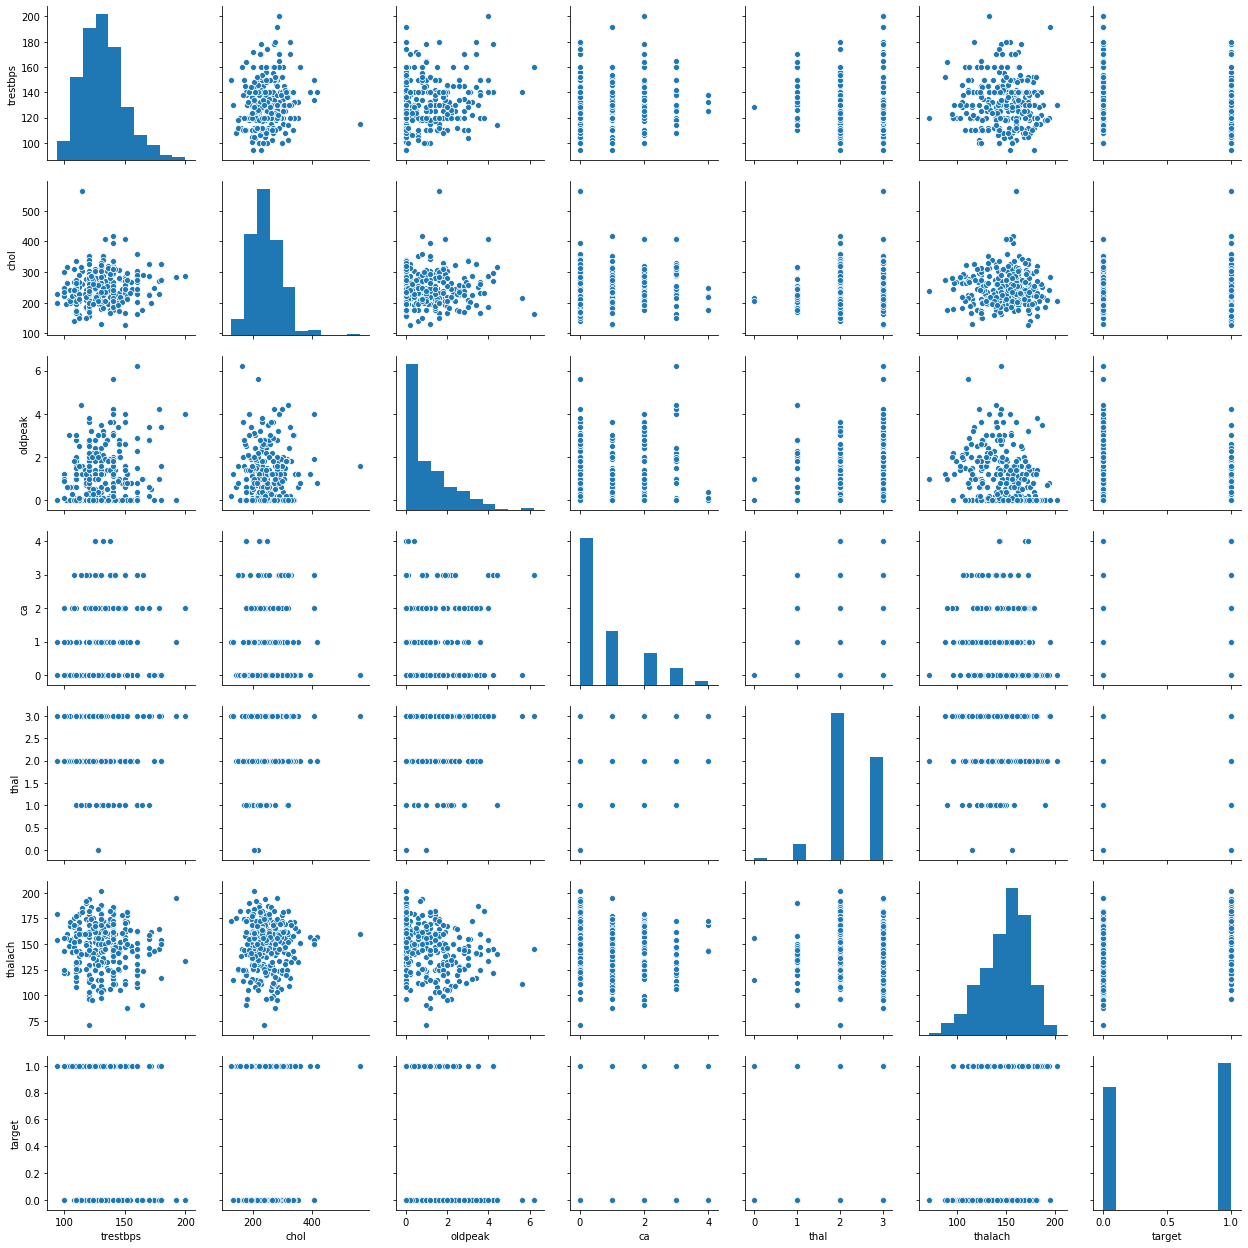

In [43]:
sns.pairplot(df[CorField])
plt.show()

## ViolinPlot

In [44]:
# Убираем целевую переменную в отдельный вектор. Просто, так удобно
y = df.target
x = df.drop("target", axis = 1)

data_dia = y
data = x

# стандартизация
data_n_2 = (data - data.mean()) / (data.std())

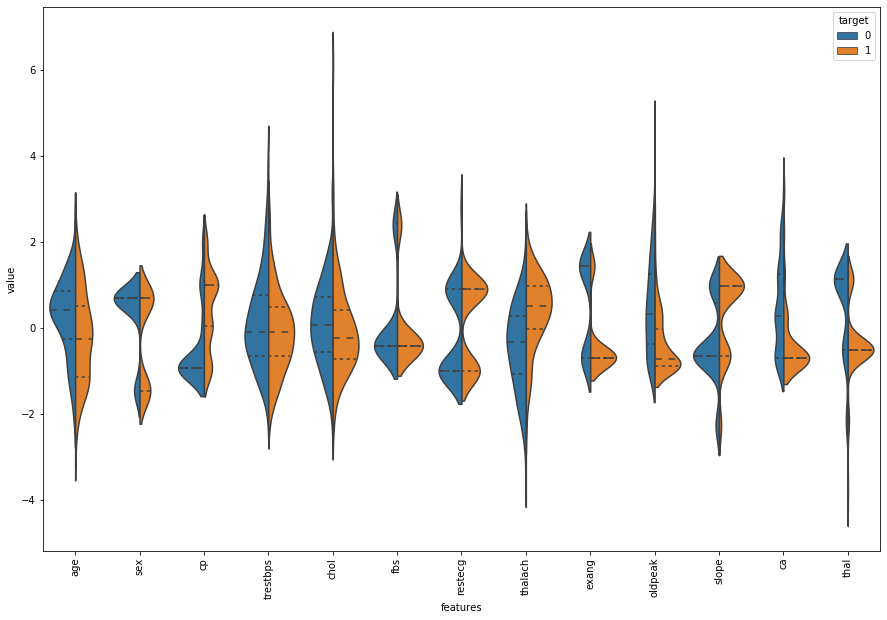

In [46]:
data = pd.concat([y,data_n_2.iloc[:,0:]],axis=1)

data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

## Swarmplot

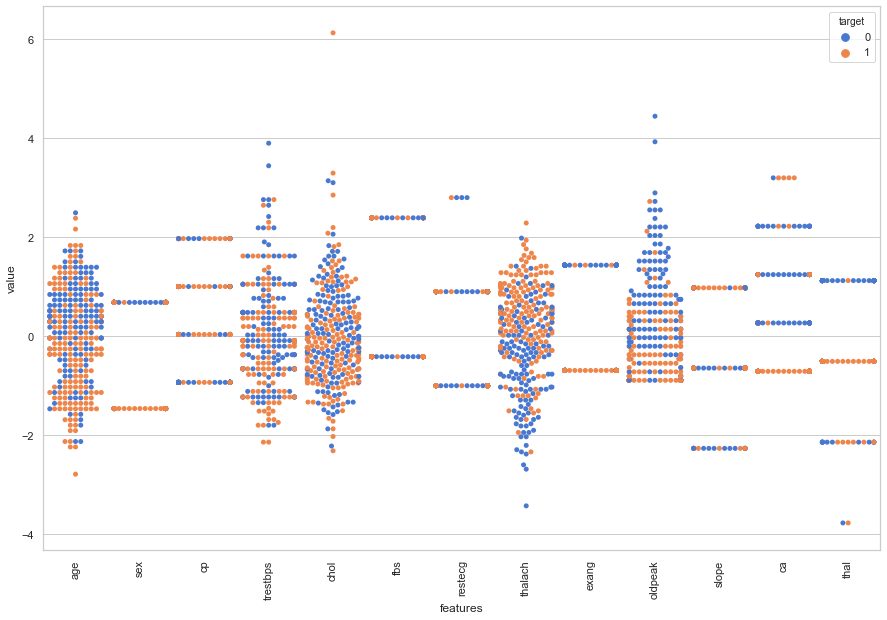

In [50]:
# Убираем целевую переменную в отдельный вектор. Просто, так удобно
y = df.target
x = df.drop("target", axis = 1)

sns.set(style="whitegrid", palette="muted")
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization

data = pd.concat([y,data_n_2.iloc[:,0:15]],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(15,10))
# tic = time.time()
sns.swarmplot(x="features", y="value", hue="target", data=data)

plt.xticks(rotation=90)
plt.show()

# Modeling

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import xgboost
from catboost import CatBoostClassifier
import lightgbm

In [182]:
xb = xgboost.XGBClassifier()
cb = CatBoostClassifier()
lb = lightgbm.LGBMClassifier(silent=False)

In [199]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [200]:
xb.fit(X_train, y_train)
cb.fit(X_train, y_train)
lb.fit(X_train, y_train)

Learning rate set to 0.005621
0:	learn: 0.6880447	total: 2.6ms	remaining: 2.6s
1:	learn: 0.6827557	total: 3.6ms	remaining: 1.8s
2:	learn: 0.6778895	total: 4.88ms	remaining: 1.62s
3:	learn: 0.6737673	total: 6.22ms	remaining: 1.55s
4:	learn: 0.6690034	total: 7.59ms	remaining: 1.51s
5:	learn: 0.6648507	total: 8.91ms	remaining: 1.48s
6:	learn: 0.6610841	total: 11.9ms	remaining: 1.69s
7:	learn: 0.6570675	total: 13ms	remaining: 1.61s
8:	learn: 0.6523126	total: 14.1ms	remaining: 1.55s
9:	learn: 0.6480984	total: 15.4ms	remaining: 1.52s
10:	learn: 0.6454620	total: 16.1ms	remaining: 1.45s
11:	learn: 0.6411034	total: 17.4ms	remaining: 1.44s
12:	learn: 0.6378298	total: 18.5ms	remaining: 1.4s
13:	learn: 0.6335074	total: 19.6ms	remaining: 1.38s
14:	learn: 0.6298595	total: 20.5ms	remaining: 1.34s
15:	learn: 0.6263365	total: 21.4ms	remaining: 1.31s
16:	learn: 0.6232942	total: 22ms	remaining: 1.27s
17:	learn: 0.6191569	total: 22.8ms	remaining: 1.25s
18:	learn: 0.6165653	total: 23.7ms	remaining: 1.22s
1

206:	learn: 0.3013411	total: 174ms	remaining: 665ms
207:	learn: 0.3006676	total: 175ms	remaining: 666ms
208:	learn: 0.3003060	total: 176ms	remaining: 667ms
209:	learn: 0.2995604	total: 177ms	remaining: 667ms
210:	learn: 0.2986315	total: 178ms	remaining: 667ms
211:	learn: 0.2973683	total: 179ms	remaining: 666ms
212:	learn: 0.2967410	total: 181ms	remaining: 667ms
213:	learn: 0.2959097	total: 182ms	remaining: 667ms
214:	learn: 0.2951404	total: 182ms	remaining: 666ms
215:	learn: 0.2947021	total: 183ms	remaining: 666ms
216:	learn: 0.2938300	total: 184ms	remaining: 665ms
217:	learn: 0.2932808	total: 185ms	remaining: 665ms
218:	learn: 0.2921114	total: 186ms	remaining: 665ms
219:	learn: 0.2917123	total: 187ms	remaining: 664ms
220:	learn: 0.2907057	total: 188ms	remaining: 664ms
221:	learn: 0.2903478	total: 189ms	remaining: 663ms
222:	learn: 0.2894159	total: 190ms	remaining: 663ms
223:	learn: 0.2892896	total: 191ms	remaining: 662ms
224:	learn: 0.2887606	total: 192ms	remaining: 661ms
225:	learn: 

379:	learn: 0.2131124	total: 345ms	remaining: 562ms
380:	learn: 0.2128375	total: 346ms	remaining: 561ms
381:	learn: 0.2125950	total: 347ms	remaining: 561ms
382:	learn: 0.2124394	total: 348ms	remaining: 560ms
383:	learn: 0.2121279	total: 349ms	remaining: 559ms
384:	learn: 0.2117526	total: 350ms	remaining: 559ms
385:	learn: 0.2114455	total: 351ms	remaining: 558ms
386:	learn: 0.2111559	total: 352ms	remaining: 557ms
387:	learn: 0.2107703	total: 353ms	remaining: 556ms
388:	learn: 0.2104502	total: 354ms	remaining: 555ms
389:	learn: 0.2101991	total: 355ms	remaining: 555ms
390:	learn: 0.2098312	total: 356ms	remaining: 554ms
391:	learn: 0.2094693	total: 357ms	remaining: 553ms
392:	learn: 0.2093077	total: 358ms	remaining: 553ms
393:	learn: 0.2089636	total: 359ms	remaining: 553ms
394:	learn: 0.2087503	total: 360ms	remaining: 551ms
395:	learn: 0.2081789	total: 361ms	remaining: 550ms
396:	learn: 0.2077338	total: 362ms	remaining: 549ms
397:	learn: 0.2075588	total: 363ms	remaining: 549ms
398:	learn: 

601:	learn: 0.1522913	total: 521ms	remaining: 345ms
602:	learn: 0.1521291	total: 523ms	remaining: 344ms
603:	learn: 0.1520123	total: 524ms	remaining: 344ms
604:	learn: 0.1516292	total: 525ms	remaining: 343ms
605:	learn: 0.1513825	total: 526ms	remaining: 342ms
606:	learn: 0.1512779	total: 527ms	remaining: 341ms
607:	learn: 0.1511119	total: 528ms	remaining: 340ms
608:	learn: 0.1510005	total: 529ms	remaining: 339ms
609:	learn: 0.1508753	total: 530ms	remaining: 339ms
610:	learn: 0.1505873	total: 531ms	remaining: 338ms
611:	learn: 0.1505129	total: 532ms	remaining: 337ms
612:	learn: 0.1504001	total: 533ms	remaining: 337ms
613:	learn: 0.1501067	total: 534ms	remaining: 336ms
614:	learn: 0.1498905	total: 535ms	remaining: 335ms
615:	learn: 0.1496691	total: 536ms	remaining: 334ms
616:	learn: 0.1494105	total: 538ms	remaining: 334ms
617:	learn: 0.1493322	total: 539ms	remaining: 333ms
618:	learn: 0.1492419	total: 540ms	remaining: 332ms
619:	learn: 0.1490910	total: 541ms	remaining: 331ms
620:	learn: 

816:	learn: 0.1159410	total: 699ms	remaining: 157ms
817:	learn: 0.1157459	total: 701ms	remaining: 156ms
818:	learn: 0.1156368	total: 703ms	remaining: 155ms
819:	learn: 0.1154832	total: 704ms	remaining: 155ms
820:	learn: 0.1153878	total: 705ms	remaining: 154ms
821:	learn: 0.1152665	total: 706ms	remaining: 153ms
822:	learn: 0.1150832	total: 707ms	remaining: 152ms
823:	learn: 0.1149969	total: 709ms	remaining: 151ms
824:	learn: 0.1148351	total: 710ms	remaining: 151ms
825:	learn: 0.1146384	total: 711ms	remaining: 150ms
826:	learn: 0.1144485	total: 712ms	remaining: 149ms
827:	learn: 0.1143704	total: 714ms	remaining: 148ms
828:	learn: 0.1142456	total: 715ms	remaining: 147ms
829:	learn: 0.1140763	total: 716ms	remaining: 147ms
830:	learn: 0.1140145	total: 717ms	remaining: 146ms
831:	learn: 0.1138568	total: 718ms	remaining: 145ms
832:	learn: 0.1137234	total: 719ms	remaining: 144ms
833:	learn: 0.1135677	total: 720ms	remaining: 143ms
834:	learn: 0.1134133	total: 721ms	remaining: 142ms
835:	learn: 

991:	learn: 0.0941926	total: 873ms	remaining: 7.04ms
992:	learn: 0.0940450	total: 874ms	remaining: 6.16ms
993:	learn: 0.0939545	total: 875ms	remaining: 5.28ms
994:	learn: 0.0937698	total: 876ms	remaining: 4.4ms
995:	learn: 0.0936573	total: 877ms	remaining: 3.52ms
996:	learn: 0.0935908	total: 878ms	remaining: 2.64ms
997:	learn: 0.0934929	total: 880ms	remaining: 1.76ms
998:	learn: 0.0934485	total: 881ms	remaining: 882us
999:	learn: 0.0933283	total: 882ms	remaining: 0us


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [201]:
def model_quality(model, X_test, y_test):
    """
    imput: Обученная модель
    output: Печатает значения основных метрик классификатора
    """
    model_name = type(model).__name__
    acc = accuracy_score(model.predict(X_test), y_test)
    pre = precision_score(model.predict(X_test), y_test)
    rec = recall_score(model.predict(X_test), y_test)
    f1 = f1_score(model.predict(X_test), y_test)

    print("{}\n\taccuracy: {:.4f} \n\tprecision: {:.4f} \n\trecall: {:.4f} \n\tf1: {:.4f}".format(
        model_name, acc, pre, rec, f1))

In [202]:
model_quality(lb, X_test, y_test)

LGBMClassifier
	accuracy: 0.7541 
	precision: 0.9062 
	recall: 0.7073 
	f1: 0.7945


In [203]:
model_quality(cb,X_test, y_test)

CatBoostClassifier
	accuracy: 0.8361 
	precision: 0.9375 
	recall: 0.7895 
	f1: 0.8571


In [204]:
model_quality(xb,X_test, y_test)

XGBClassifier
	accuracy: 0.7541 
	precision: 0.8750 
	recall: 0.7179 
	f1: 0.7887


**Примечание**: 

на данном примере из трех моделей CatBoostClassifier показывает лучшие результаты

# Model tuning

In [206]:
cb_tunied = CatBoostClassifier()

In [220]:
df.shape

(303, 14)

In [227]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# намеренно выделил больше данных для обсучающей выборке т.к. во время тренеровки 
# катбуст делит обучающую выборку еще раз на трейнт и тест 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 13), (61, 13), (242,), (61,))

In [228]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cb_tunied.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.2685228	best: 0.2685228 (0)	total: 789ms	remaining: 30.8s
1:	loss: 0.3089603	best: 0.2685228 (0)	total: 1.47s	remaining: 27.9s
2:	loss: 0.2802581	best: 0.2685228 (0)	total: 2.17s	remaining: 26.8s
3:	loss: 0.2850897	best: 0.2685228 (0)	total: 2.8s	remaining: 25.2s
4:	loss: 0.2631193	best: 0.2631193 (4)	total: 3.46s	remaining: 24.2s
5:	loss: 0.2654577	best: 0.2631193 (4)	total: 4.17s	remaining: 23.7s
6:	loss: 0.2751809	best: 0.2631193 (4)	total: 4.82s	remaining: 22.7s
7:	loss: 0.2752492	best: 0.2631193 (4)	total: 5.47s	remaining: 21.9s
8:	loss: 0.2806814	best: 0.2631193 (4)	total: 6.11s	remaining: 21.1s
9:	loss: 0.2783043	best: 0.2631193 (4)	total: 6.79s	remaining: 20.4s
10:	loss: 0.2546460	best: 0.2546460 (10)	total: 7.62s	remaining: 20.1s
11:	loss: 0.3009732	best: 0.2546460 (10)	total: 8.4s	remaining: 19.6s
12:	loss: 0.2603030	best: 0.2546460 (10)	total: 9.29s	remaining: 19.3s
13:	loss: 0.2544895	best: 0.2544895 (13)	total: 10.1s	remaining: 18.8s
14:	loss: 0.2637227	best: 0.

In [163]:
grid_search_result

{'params': {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

In [231]:
model_quality(cb_tunied, X_test, y_test)

CatBoostClassifier
	accuracy: 0.7541 
	precision: 0.6786 
	recall: 0.7600 
	f1: 0.7170


МОДЕЛЬ ЛУЧШЕ НЕ СТАЛА, ВОЗМОЖНО ЭТО ИЗ-ЗА УМЕНЬШЕНИЕ ОБУЧАЮЩЕЙ ВЫБОРКИ